## ALS implementation using Spark for Movie Recommendation

Install Basic Libraries

Import basic spark libraries

In [1]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql import SparkSession

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1635485409409_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
spark = SparkSession.builder.appName("als").getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Load Movie Ratings Data

In [3]:
ratings = spark.read.csv("s3a://sparkdemonstration-mlc/ratings.csv",inferSchema=True, header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
ratings.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
|     1|   1260|   3.5|1147877857|
|     1|   1653|   4.0|1147868097|
|     1|   2011|   2.5|1147868079|
|     1|   2012|   2.5|1147868068|
|     1|   2068|   2.5|1147869044|
|     1|   2161|   3.5|1147868609|
|     1|   2351|   4.5|1147877957|
|     1|   2573|   4.0|1147878923|
|     1|   2632|   5.0|1147878248|
|     1|   2692|   5.0|1147869100|
+------+-------+------+----------+
only showing top 20 rows

In [5]:
ratings.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

25000095

In [6]:
ratings.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+------------------+--------------------+
|summary|            userId|           movieId|            rating|           timestamp|
+-------+------------------+------------------+------------------+--------------------+
|  count|          25000095|          25000095|          25000095|            25000095|
|   mean| 81189.28115381162|21387.981943268616| 3.533854451353085|1.2156014431215513E9|
| stddev|46791.715897457056| 39198.86210106022|1.0607439611423508|2.2687580805953687E8|
|    min|                 1|                 1|               0.5|           789652009|
|    max|            162541|            209171|               5.0|          1574327703|
+-------+------------------+------------------+------------------+--------------------+

## Visualize ratings data in Rating Matrix format

In [7]:
rating_small = spark.read.csv("s3a://sparkdemonstration-mlc/ratings_small.csv",inferSchema=True, header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
rating_small.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

40

In [9]:
rating_small.createTempView("rating_small_table")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
spark.sql("select * from rating_small_table").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|  6947|     11|   2.0|1130275865|
|  6947|     19|   3.5|1130275926|
|  6947|    410|   1.5|1130275858|
|  6947|    442|   3.5|1130275932|
|  6947|    474|   4.0|1130275893|
|  6947|    708|   2.5|1130275957|
|  6947|    786|   2.5|1130275936|
|  6947|    912|   5.0|1130275870|
|  6947|   1221|   5.0|1130275875|
|  6947|   1307|   3.5|1130275904|
|  6947|   1527|   4.0|1130275882|
|  6947|   1610|   4.0|1130275942|
|  6947|   1784|   4.0|1130275929|
|  6947|   1923|   4.0|1130275901|
|  6947|   1961|   4.0|1130275896|
|  6947|   2987|   3.5|1130275959|
|  6947|   2997|   4.5|1130275890|
|  6947|   4306|   3.5|1130275951|
|  6947|   4993|   5.0|1130275944|
|  6947|  36529|   3.0|1130276051|
+------+-------+------+----------+
only showing top 20 rows

In [11]:
spark.sql("select * from rating_small_table").groupBy("userId").pivot("movieId").max("rating").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+
|userId|  11|  16|  19| 236| 410| 432| 442| 474| 708| 786| 912|1080|1219|1221|1258|1288|1307|1527|1610|1680|1784|1923|1961|1967|2012|2115|2406|2599|2618|2640|2710|2791|2797|2987|2997|3897|4306|4993|5222|36529|
+------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+
|  6947| 2.0|null| 3.5|null| 1.5|null| 3.5| 4.0| 2.5| 2.5| 5.0|null|null| 5.0|null|null| 3.5| 4.0| 4.0|null| 4.0| 4.0| 4.0|null|null|null|null|null|null|null|null|null|null| 3.5| 4.5|null| 3.5| 5.0|null|  3.0|
|  6971|null| 3.0|null| 3.0|null| 1.0|null|null|null|null|null| 5.0| 1.0|null| 1.0| 4.5|null|null|null| 5.0|null|null|null| 4.0| 0.5| 3.5| 3.0| 5.0| 4.5| 1.0| 2

### Load Movies Data

In [12]:
movies = spark.read.csv("s3a://sparkdemonstration-mlc/movies.csv",inferSchema=True, header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
movies.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [14]:
movies.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

62423

### Split the Rating data to Train, Validation & Test set

In [15]:
(training,validation,test) = ratings.randomSplit([0.6, 0.2, 0.2], seed=99)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
training.count(), validation.count(), test.count(), ratings.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(14999312, 4999424, 5001359, 25000095)

## ALS Model

Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics

In [17]:
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",maxIter=5, regParam=0.05, coldStartStrategy="drop")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model Training

In [18]:
model = als.fit(training)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
model

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ALS_0028cf8604b0

In [20]:
predictions = model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
predictions

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[userId: int, movieId: int, rating: double, timestamp: int, prediction: float]

In [22]:
predictions.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|114572|    148|   2.0| 838460783| 2.3427248|
|124207|    148|   3.0| 847246861| 1.5648663|
|159730|    148|   3.0| 842162037| 2.7180588|
| 99010|    148|   3.0| 837652881| 2.7796779|
| 57779|    148|   2.0| 835816780|  2.345887|
|  6491|    148|   4.0|1500217059|  2.788311|
|145182|    148|   3.0| 944952722|  2.665872|
| 84667|    148|   5.0| 832207176| 3.1719656|
|162516|    148|   2.0|1175649451| 2.1095157|
| 73977|    148|   2.0| 965106877| 3.3122435|
|109156|    148|   2.0| 989289917|  2.422843|
|110863|    148|   3.0| 832312374| 2.7154894|
| 19478|    148|   2.0| 954478151| 2.7890973|
| 58005|    148|   3.0|1112745159| 2.4759774|
| 39945|    148|   3.0| 837602927| 2.9504352|
| 50289|    148|   1.0| 833673768| 2.2948513|
| 18628|    148|   2.0| 916754151| 2.8714876|
|118698|    148|   4.0| 974082717| 3.1855123|
| 68262|    148|   4.0| 942234567|

## Calculate the RMSE error

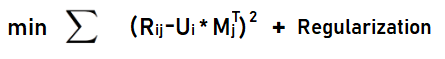

Evaluate the model by computing the RMSE on the test data

In [23]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
rmse = evaluator.evaluate(predictions) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
rmse

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.8104774921521035

## How to Choose optimal maxIter value

While training the model we've used maxIter value as 5<br>which means there will be 5 iterations of the complete model to get the least error.<br>
Its possible that we can get most optimal model is less than 5 or more then 5 iterations.<br>
You have seen in the video that the iteration **value = 3** is optimal value to train the model.


We can not run the python commands here when we set the kernel as PySpark to plot the graph between number of iterations and RMSE values.

In [26]:
iter_array = [1,3,5,7]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
rmse_list =[]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
for itervalue in iter_array:
    print("Iteration value: ", itervalue)
    als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",maxIter=itervalue, regParam=0.05, coldStartStrategy="drop")
    model = als.fit(validation)
    predictions = model.transform(validation)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    rmse_list.append(rmse)
    print("Rmse value: ", rmse)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Iteration value:  1
Rmse value:  3.2043396331414393
Iteration value:  3
Rmse value:  0.7375388857886189
Iteration value:  5
Rmse value:  0.6742632141386962
Iteration value:  7
Rmse value:  0.6595486009742331

## Now train Model with most optimal maxIter value

In [30]:
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",maxIter=7, regParam=0.05, coldStartStrategy="drop")
model = als.fit(test)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
predictions.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
| 99010|    148|   3.0| 837652881|  2.666457|
| 57779|    148|   2.0| 835816780| 1.3798213|
|145182|    148|   3.0| 944952722| 2.6197789|
| 84667|    148|   5.0| 832207176|  3.971609|
|162516|    148|   2.0|1175649451| 2.6780653|
| 75209|    148|   2.0|1361853682| 2.6394649|
|110863|    148|   3.0| 832312374|   2.98804|
| 19478|    148|   2.0| 954478151| 2.2420764|
| 58005|    148|   3.0|1112745159| 2.3642092|
| 39945|    148|   3.0| 837602927| 2.9321258|
| 50289|    148|   1.0| 833673768| 1.7590718|
| 18628|    148|   2.0| 916754151| 3.1940727|
|118698|    148|   4.0| 974082717| 3.6210556|
| 68262|    148|   4.0| 942234567|  4.028578|
| 91265|    148|   4.0| 836315177| 2.9091434|
| 92046|    148|   3.0|1021775913| 2.6122007|
|  7836|    148|   3.0| 842266581| 3.1445055|
|138583|    148|   2.0| 880550880| 2.7026978|
| 48928|    148|   2.0| 974930221|

## Generate top 10 User Recommendation for a Movie

In [31]:
movieRecs = model.recommendForAllItems(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
movieRecs.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|    148|[[136157, 6.91338...|
|    463|[[52246, 6.544544...|
|    471|[[141970, 6.35196...|
|    496|[[110910, 7.63708...|
|    833|[[157874, 7.47122...|
|   1088|[[160413, 7.03224...|
|   1238|[[69781, 6.567919...|
|   1342|[[90626, 6.547233...|
|   1580|[[86599, 5.606989...|
|   1591|[[42602, 5.793104...|
|   1645|[[161310, 6.23709...|
|   1829|[[79703, 7.842149...|
|   1959|[[98928, 7.325040...|
|   2122|[[29663, 6.588364...|
|   2142|[[3582, 5.343187]...|
|   2366|[[36043, 7.618140...|
|   2659|[[86599, 7.146479...|
|   2866|[[86085, 6.407417...|
|   3175|[[66208, 6.822761...|
|   3749|[[90626, 8.066495...|
+-------+--------------------+
only showing top 20 rows

Join with the Movies data

In [33]:
movies_joined = movieRecs.join(movies, on=['movieId'], how='Left')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
movies_joined.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+--------------------+--------------------+
|movieId|     recommendations|               title|              genres|
+-------+--------------------+--------------------+--------------------+
|    148|[[136157, 6.91338...|Awfully Big Adven...|               Drama|
|    463|[[52246, 6.544544...|Guilty as Sin (1993)|Crime|Drama|Thriller|
|    471|[[141970, 6.35196...|Hudsucker Proxy, ...|              Comedy|
|    496|[[110910, 7.63708...|What Happened Was...|Comedy|Drama|Roma...|
|    833|[[157874, 7.47122...|High School High ...|              Comedy|
|   1088|[[160413, 7.03224...|Dirty Dancing (1987)|Drama|Musical|Rom...|
|   1238|[[69781, 6.567919...|   Local Hero (1983)|              Comedy|
|   1342|[[90626, 6.547233...|     Candyman (1992)|     Horror|Thriller|
|   1580|[[86599, 5.606989...|Men in Black (a.k...|Action|Comedy|Sci-Fi|
|   1591|[[42602, 5.793104...|        Spawn (1997)|Action|Adventure|...|
|   1645|[[161310, 6.23709...|The Devil's Advoc...|

In [35]:
movies_joined.head(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(movieId=148, recommendations=[Row(userId=136157, rating=6.913381576538086), Row(userId=86599, rating=6.886188507080078), Row(userId=112096, rating=6.652641296386719), Row(userId=7620, rating=6.60024356842041), Row(userId=161504, rating=6.564905166625977), Row(userId=17244, rating=6.505630970001221), Row(userId=25548, rating=6.49863338470459), Row(userId=22466, rating=6.495912551879883), Row(userId=68018, rating=6.494911193847656), Row(userId=89194, rating=6.471474647521973)], title='Awfully Big Adventure, An (1995)', genres='Drama')]

## Generate top 10 Recommended Movies for all the Users

In [36]:
userRecs = model.recommendForAllUsers(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
y =userRecs.head(1)[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
y['userId']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

148

In [39]:
y['recommendations']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(movieId=153184, rating=5.870885372161865), Row(movieId=172737, rating=5.777832984924316), Row(movieId=194060, rating=5.676609039306641), Row(movieId=152890, rating=5.650399208068848), Row(movieId=66857, rating=5.642359256744385), Row(movieId=96075, rating=5.543984889984131), Row(movieId=170595, rating=5.506099224090576), Row(movieId=49085, rating=5.486140727996826), Row(movieId=56614, rating=5.410759925842285), Row(movieId=142677, rating=5.379752159118652)]

## Get top 20 Movies Prediction

In [40]:
top_movies = predictions.orderBy('prediction', ascending = False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
top_movies.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
| 71998|   1347|   5.0|1506241881|   6.10514|
| 93724|   7153|   5.0|1463073821| 6.0138054|
| 43087| 163809|   5.0|1478720196|  5.954564|
| 73461|  51662|   5.0|1498549798|  5.845251|
| 65187| 136445|   5.0|1518428687| 5.8331094|
| 80817|    527|   5.0| 847096841| 5.8268566|
| 73461|   1676|   5.0|1498550291| 5.8190174|
|140307|   7153|   5.0|1081193757|  5.817561|
| 90531|   1271|   5.0|1562015416|  5.799472|
| 53798|    720|   5.0|1052786324|  5.794604|
|160195|    107|   5.0|1405985691| 5.7623425|
| 17086| 159819|   5.0|1524562372| 5.7408147|
|156545|   6942|   5.0|1436123216|  5.736396|
| 24869|   1197|   5.0|1369601019|  5.735368|
| 24360|   1196|   4.5|1264860648| 5.7296696|
|103880|   1345|   5.0|1111533750| 5.7062078|
| 19663|   2005|   5.0|1547166769| 5.6924562|
|121370|    720|   5.0|1300490762|  5.691756|
|147788|   2959|   5.0|1437613221|

In [42]:
top_movie_names = top_movies.join(movies, on=['movieId'], how ='left')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
top_movie_names.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------+------+----------+----------+--------------------+--------------------+
|movieId|userId|rating| timestamp|prediction|               title|              genres|
+-------+------+------+----------+----------+--------------------+--------------------+
|   1347| 71998|   5.0|1506241881|   6.10514|Nightmare on Elm ...|     Horror|Thriller|
|   7153| 93724|   5.0|1463073821| 6.0138054|Lord of the Rings...|Action|Adventure|...|
| 163809| 43087|   5.0|1478720196|  5.954564|Over the Garden W...|Adventure|Animati...|
|  51662| 73461|   5.0|1498549798|  5.845251|          300 (2007)|Action|Fantasy|Wa...|
| 136445| 65187|   5.0|1518428687| 5.8331094|George Carlin: Ba...|              Comedy|
|    527| 80817|   5.0| 847096841| 5.8268566|Schindler's List ...|           Drama|War|
|   1676| 73461|   5.0|1498550291| 5.8190174|Starship Troopers...|       Action|Sci-Fi|
|   7153|140307|   5.0|1081193757|  5.817561|Lord of the Rings...|Action|Adventure|...|
|   1271| 90531|   5.0|156201541